In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# longitude: x coordinate
# latitude: y coordinate

liga_coords = {
    "Premier League": (-1.234069,52.915917),
    "Bundesliga": (9.94846,51.525438),
    "Ligue 1": (2.373969,46.812233),
    "Serie A": (12.720198,42.673877),
    "LaLiga": (-3.862441,40.330021)
}

from scipy.optimize import fsolve

def circle_interpolation(start_league: str, 
                         end_league: str, 
                         RADIUS: float,
                         year:int,
                         transfer_type:str) -> pd.DataFrame:


# (long, lat)

    start = liga_coords[start_league]
    end = liga_coords[end_league]

    def equations(vars):
        x, y = vars
        eq1 = (start[0] - x)**2 + (start[1] - y)**2 - RADIUS**2
        eq2 = (end[0] - x)**2 + (end[1] - y)**2 - RADIUS**2
        return [eq1, eq2]

    # Initial guess for x and y
    initial_guess = [0, 0]

    # Solve the equations
    solution = fsolve(equations, initial_guess)

    # Extracting solutions for x and y
    x_solution, y_solution = solution


    theta = np.linspace(0,1,10000) * 2 * np.pi
    x = x_solution + RADIUS * np.cos(theta)
    y = y_solution + RADIUS * np.sin(theta)


    xy = np.stack([x,y])

    # np.arctan2(y,x)
    start_rad = np.arctan2(end[1]-y_solution,end[0]-x_solution)
    end_rad = np.arctan2(start[1]-y_solution,start[0]-x_solution)

    xc = xy[0,:][(start_rad < np.arctan2(xy[1,:]-y_solution,xy[0,:]-x_solution)) & (np.arctan2(xy[1,:]-y_solution,xy[0,:]-x_solution) < end_rad)]
    yc = xy[1,:][(start_rad < np.arctan2(xy[1,:]-y_solution,xy[0,:]-x_solution)) & (np.arctan2(xy[1,:]-y_solution,xy[0,:]-x_solution) < end_rad)]

    n = len(xc)

    df = pd.DataFrame({"Year": [year]*n,
                       "Liga1": [start_league]*n,
                       "Liga2": [end_league]*n,
                       "Transfer Type": [transfer_type]*n,
                       'Longitude': xc, 
                       'Latitude':yc})
    if len(df) == 0:
        return circle_interpolation(start_league=end_league,
                                    end_league=start_league,
                                    RADIUS=RADIUS,
                                    year=year,
                                    transfer_type=transfer_type)
    return df


In [22]:

ligas = set()

for liga1 in liga_coords.keys():
    for liga2 in liga_coords.keys():
        if liga1 != liga2:
            ligas.add((liga1,liga2))

transfer_types = [(40,"Import"), (30,"Export")]
years = [2018,2019,2020,2021,2022]
dfs = []

for radius, transfer_type in transfer_types:
    for year in years:
        for liga1, liga2 in ligas:
            dfs.append(circle_interpolation(
            start_league=liga1, 
            end_league=liga2,
            RADIUS=radius,
            year=year, 
            transfer_type=transfer_type)
            )



df = pd.concat(dfs)
df


,Year,Liga1,Liga2,Transfer Type,Longitude,Latitude
0,2018,Ligue 1,Serie A,Import,12.716848,42.675796
1,2018,Ligue 1,Serie A,Import,12.695033,42.688282
2,2018,Ligue 1,Serie A,Import,12.673210,42.700753
3,2018,Ligue 1,Serie A,Import,12.651379,42.713211
4,2018,Ligue 1,Serie A,Import,12.629541,42.725656
...,...,...,...,...,...,...
684,2022,Premier League,LaLiga,Export,-1.232637,52.537838
685,2022,Premier League,LaLiga,Export,-1.232595,52.556690
686,2022,Premier League,LaLiga,Export,-1.232566,52.575541
687,2022,Premier League,LaLiga,Export,-1.232548,52.594392


/var/folders/3h/hhvlktwj1rzfznpk5wz5w45w0000gn/T/ipykernel_32123/2049949484.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


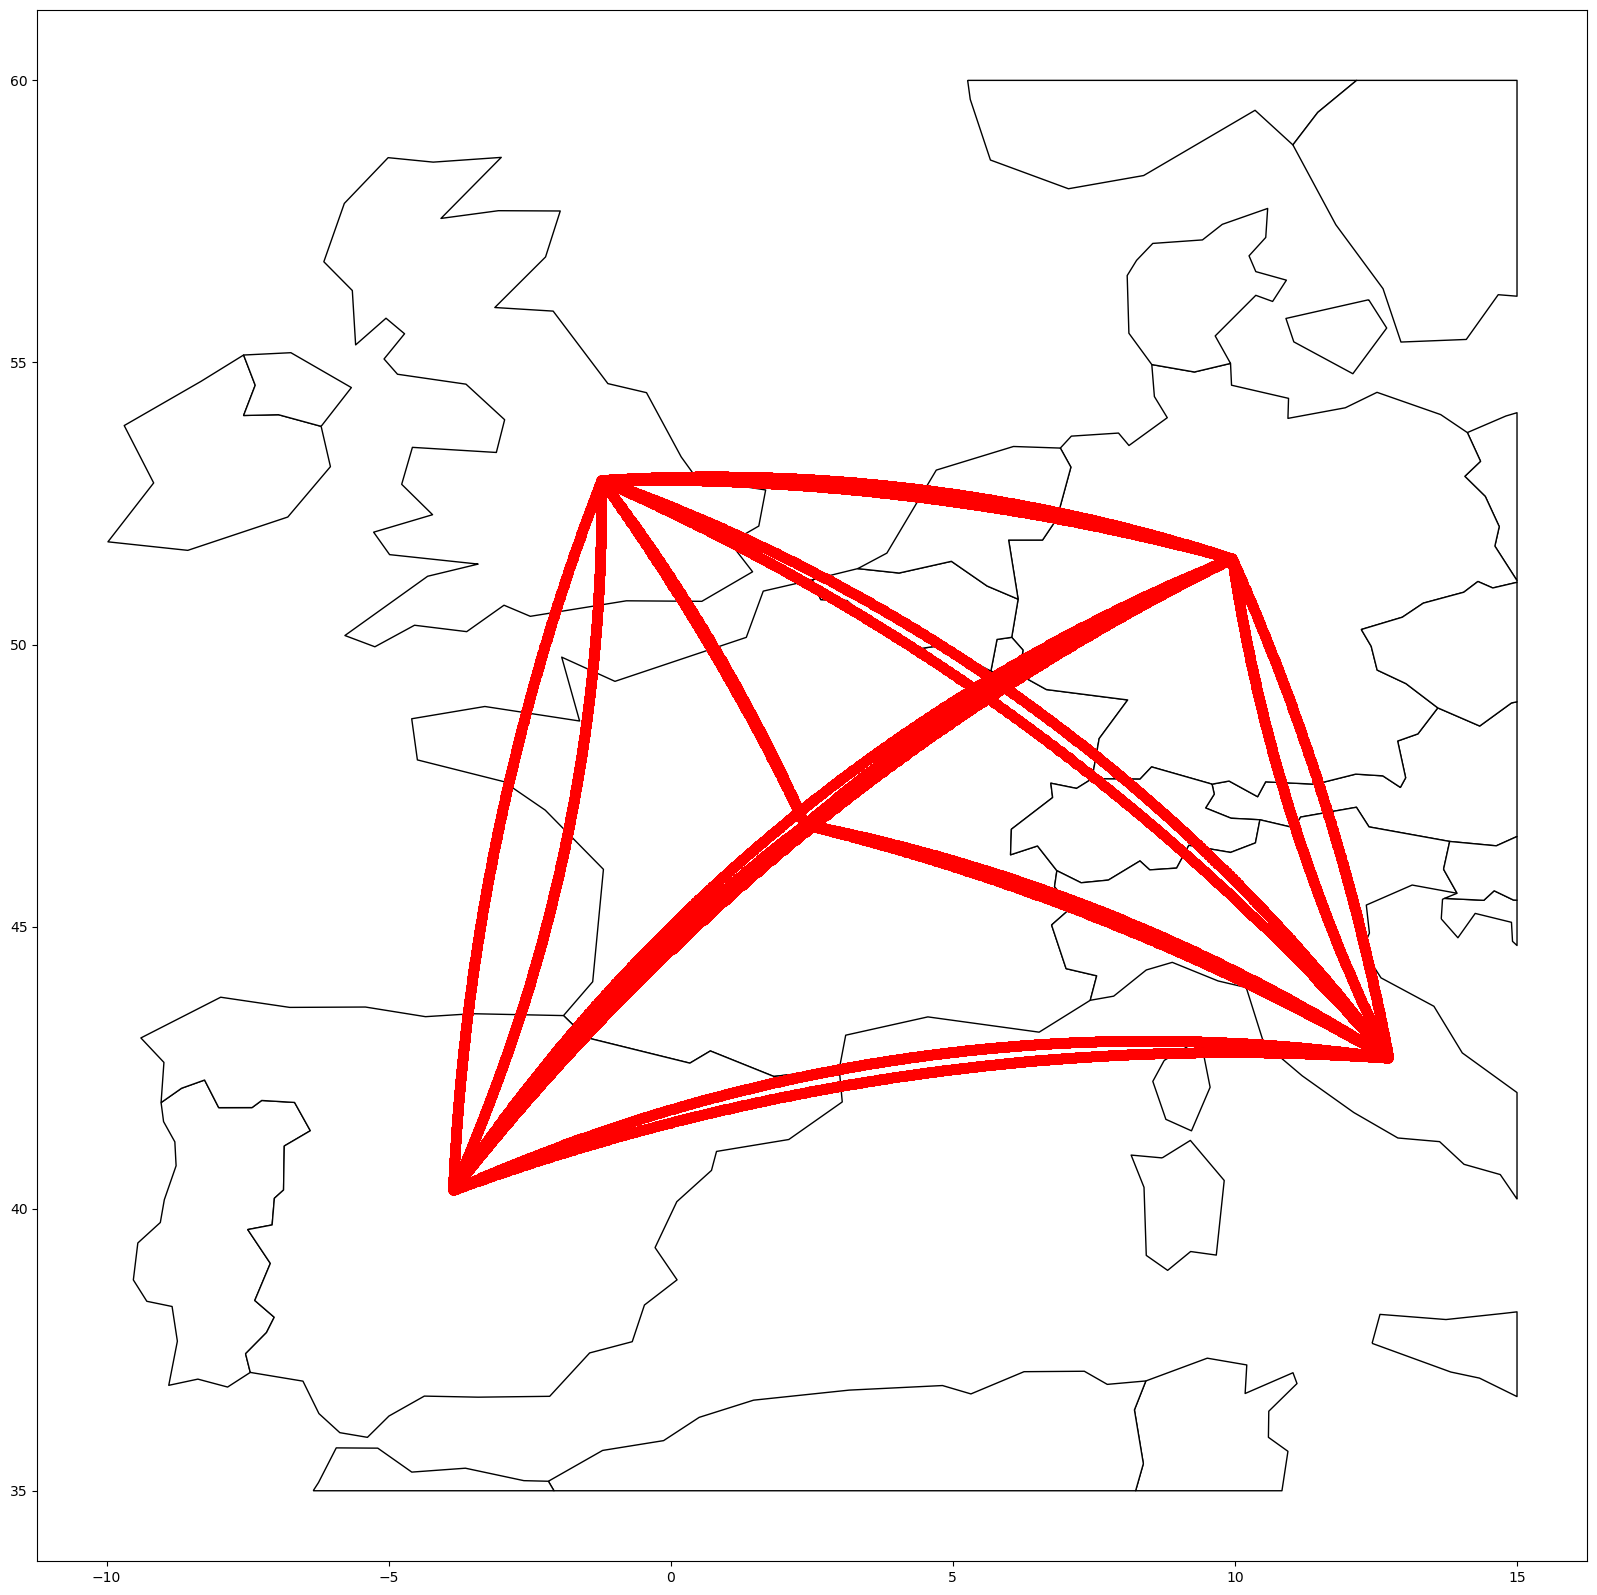

In [20]:

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20, 100))

# Create a base map
world.clip_by_rect(ymin=35, ymax=60, xmin=-10, xmax=15).plot(ax=ax, color="white", edgecolor="black")

# Plot the GeoDataFrame on the base map
gdf.plot(ax=ax, color="red")
plt.show()

In [ ]:
df

,Longitude,Latitude
0,12.704717,42.691534
1,12.688135,42.710423
2,12.671541,42.729303
3,12.654935,42.748171
4,12.638317,42.767029
...,...,...
689,-1.137239,52.873094
690,-1.160216,52.883283
691,-1.183200,52.893458
692,-1.206190,52.903619
